In [240]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import sklearn.linear_model
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime

## Read in the Data, and convert the index to datetime

In [2]:
grains = pd.read_csv('Grains_Clean.csv')

In [3]:
meat_oil = pd.read_csv('Meat_Oil_Clean.csv')

In [4]:
grains = grains.set_index(pd.date_range('1867-1-1', periods=150, freq='A'))

In [5]:
grains.head()

,Corn_Price,Barley_Price,Oats_Price,Sorghum_Price
1867-12-31 00:00:00,0.66,0.95,0.47,NaN
1868-12-31 00:00:00,0.78,1.22,0.59,NaN
1869-12-31 00:00:00,0.62,1.49,0.54,NaN
1870-12-31 00:00:00,0.73,0.87,0.46,NaN
1871-12-31 00:00:00,0.52,0.85,0.43,NaN


In [6]:
meat_oil = meat_oil.set_index(pd.date_range('1986-1-1', periods=360, freq='M'))

In [7]:
meat_oil.head()

,Beef_Farm_Price,Beef_Wholesale_Price,Beef_Retail_Price,Pork_Farm_Price,Pork_Wholesale_Price,Pork_Retail_Price,Chicken_Retail_Price,Oil_Price
1986-01-31,129.0,152.6,232.9,85.55,104.15,178.80,119.59,22.93
1986-02-28,121.6,143.1,228.5,81.62,100.58,178.06,117.20,15.46
1986-03-31,120.4,141.0,226.4,76.90,97.11,175.42,115.46,12.61
1986-04-30,116.8,137.8,223.1,76.01,96.38,171.61,116.44,12.84
1986-05-31,121.0,142.8,222.9,89.83,108.04,171.71,116.49,15.38


## Convert Meat Prices from Cents into Dollars

In [8]:
def cents_to_dollars(x):
    return x/100

cent_prices = ['Beef_Farm_Price','Beef_Wholesale_Price', 'Beef_Retail_Price',
              'Pork_Farm_Price', 'Pork_Wholesale_Price', 'Pork_Retail_Price',
              'Chicken_Retail_Price']

meat_oil[cent_prices] = meat_oil[cent_prices].apply(cents_to_dollars)

In [9]:
meat_oil.head()

,Beef_Farm_Price,Beef_Wholesale_Price,Beef_Retail_Price,Pork_Farm_Price,Pork_Wholesale_Price,Pork_Retail_Price,Chicken_Retail_Price,Oil_Price
1986-01-31,1.290,1.526,2.329,0.8555,1.0415,1.7880,1.1959,22.93
1986-02-28,1.216,1.431,2.285,0.8162,1.0058,1.7806,1.1720,15.46
1986-03-31,1.204,1.410,2.264,0.7690,0.9711,1.7542,1.1546,12.61
1986-04-30,1.168,1.378,2.231,0.7601,0.9638,1.7161,1.1644,12.84
1986-05-31,1.210,1.428,2.229,0.8983,1.0804,1.7171,1.1649,15.38


## Join the Two Dataframes, and Populate Null Values. Then Split into Train/Test groups

The data collected for meat and oil has monthly intervals, while the data collected for grains is averaged for the whole year. Making the assumption that the yearly average grain prices are also true at the montly time points for that same year allows the comparison of more data points from the meat and oil data. After joining the data, it is then split using 70% as training data, and 30% for testing and validation.

In [10]:
meat_oil_grains = meat_oil.join(grains, how='left').fillna(method='bfill')

In [11]:
meat_oil_grains.head()

,Beef_Farm_Price,Beef_Wholesale_Price,Beef_Retail_Price,Pork_Farm_Price,Pork_Wholesale_Price,Pork_Retail_Price,Chicken_Retail_Price,Oil_Price,Corn_Price,Barley_Price,Oats_Price,Sorghum_Price
1986-01-31,1.290,1.526,2.329,0.8555,1.0415,1.7880,1.1959,22.93,2.23,1.98,1.23,1.93
1986-02-28,1.216,1.431,2.285,0.8162,1.0058,1.7806,1.1720,15.46,2.23,1.98,1.23,1.93
1986-03-31,1.204,1.410,2.264,0.7690,0.9711,1.7542,1.1546,12.61,2.23,1.98,1.23,1.93
1986-04-30,1.168,1.378,2.231,0.7601,0.9638,1.7161,1.1644,12.84,2.23,1.98,1.23,1.93
1986-05-31,1.210,1.428,2.229,0.8983,1.0804,1.7171,1.1649,15.38,2.23,1.98,1.23,1.93


In [270]:
train = meat_oil_grains[:180]
test = meat_oil_grains[180:]

## Exploratory Analysis: We look at grain, meat, and oil prices over time to see trends and correlation

In [14]:
beef_prices = ['Beef_Farm_Price','Beef_Wholesale_Price', 'Beef_Retail_Price']
pork_prices = ['Pork_Farm_Price', 'Pork_Wholesale_Price', 'Pork_Retail_Price']
retail_meat = ['Beef_Retail_Price', 'Pork_Retail_Price', 'Chicken_Retail_Price']
grain_prices = ['Corn_Price', 'Oats_Price', 'Barley_Price', 'Sorghum_Price']

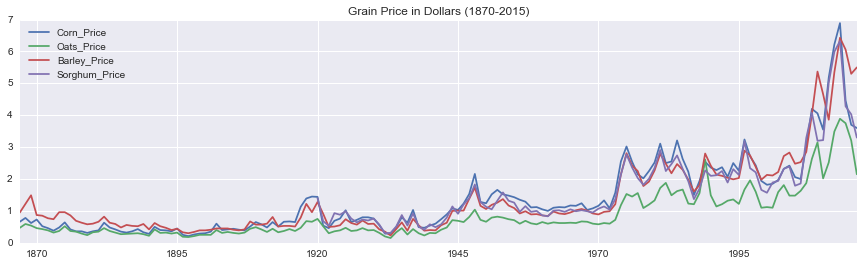

In [15]:
# This graph uses the unjoined grain data to incorporate more values in time, to better illustrate trend. Prices follow
# a general increasing trend over time.
grains[grain_prices].plot(title='Grain Price in Dollars (1870-2015)',
            figsize=(15,4)
           )

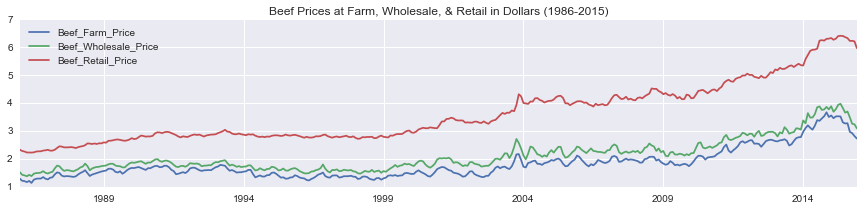

In [16]:
# This shows upward trend of beef prices over time with high correlation
meat_oil_grains[beef_prices].plot(figsize=(15,3),
                                 title='Beef Prices at Farm, Wholesale, & Retail in Dollars (1986-2015)')

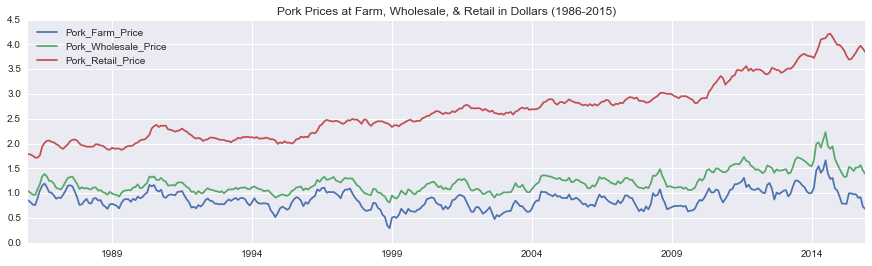

In [17]:
# This shows upward trend of pork prices over time, except between farm and retail (see matrix below)
meat_oil_grains[pork_prices].plot(figsize=(15,4),
                                 title='Pork Prices at Farm, Wholesale, & Retail in Dollars (1986-2015)')

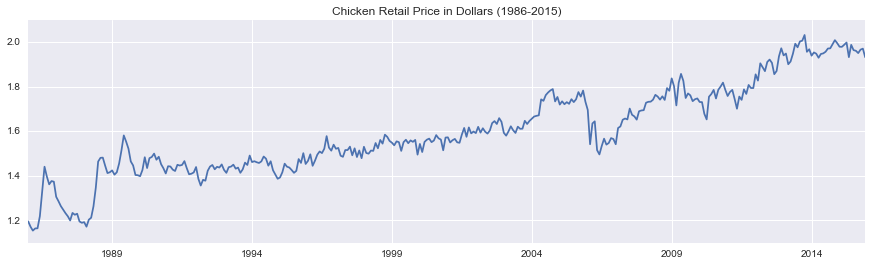

In [18]:
# Chicken prices trend up over time
meat_oil_grains['Chicken_Retail_Price'].plot(figsize=(15,4),
                                            title='Chicken Retail Price in Dollars (1986-2015)')

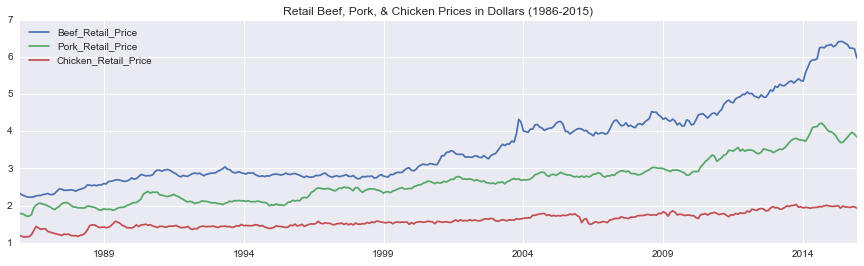

In [19]:
# retail meat prices have the highest correlation, according to the matrix below
meat_oil_grains[retail_meat].plot(figsize=(15,4),
                                 title='Retail Beef, Pork, & Chicken Prices in Dollars (1986-2015)')

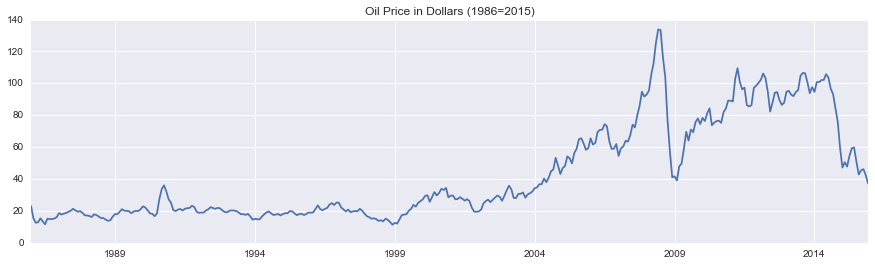

In [20]:
# Oil prices trend upward, with several rapid adjustments in the past 5 years
meat_oil_grains['Oil_Price'].plot(figsize=(15,4),
                                 title='Oil Price in Dollars (1986-2015)')

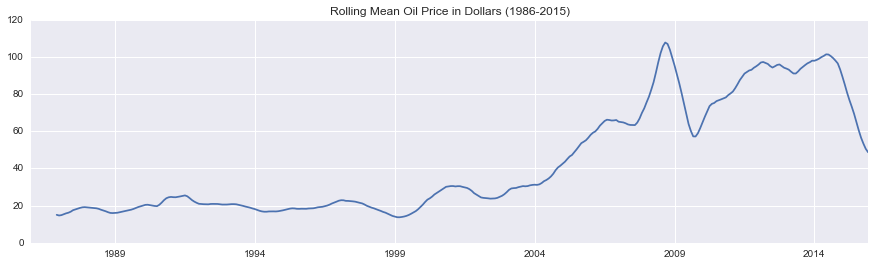

In [45]:
# A rolling average graph smooths the plot to illustrate the generally upward trend
pd.rolling_mean(meat_oil_grains['Oil_Price'],12).plot(figsize=(15,4),
                                                      title='Rolling Mean Oil Price in Dollars (1986-2015)')

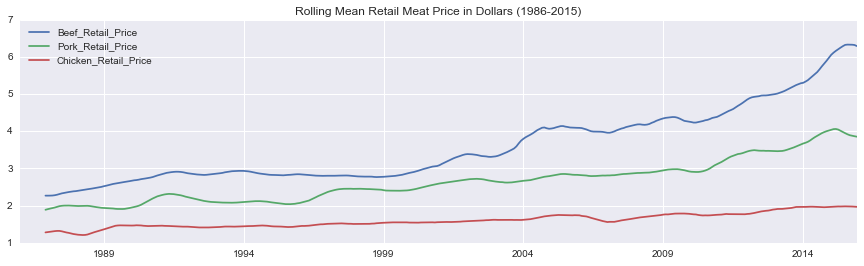

In [48]:
# Rolling average of retail prices to compare to oil
pd.rolling_mean(meat_oil_grains[retail_meat],12).plot(figsize=(15,4),
                                                  title='Rolling Mean Retail Meat Price in Dollars (1986-2015)')

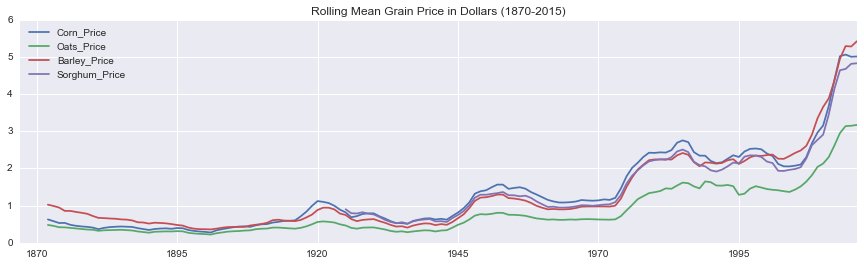

In [50]:
# Rolling average of grain prices to compare to oil - this illustrates the increase in recent years
pd.rolling_mean(grains[grain_prices],6).plot(figsize=(15,4),
                                             title='Rolling Mean Grain Price in Dollars (1870-2015)')

In [21]:
# Most correlations are high, with a notable exception of pork prices having low correlation to grain and oil prices, 
# this suggests that there might be other factors not considered in the pork business
meat_oil_grains.corr()

,Beef_Farm_Price,Beef_Wholesale_Price,Beef_Retail_Price,Pork_Farm_Price,Pork_Wholesale_Price,Pork_Retail_Price,Chicken_Retail_Price,Oil_Price,Corn_Price,Barley_Price,Oats_Price,Sorghum_Price
Beef_Farm_Price,1.000000,0.988965,0.941667,0.489333,0.786363,0.888475,0.825875,0.731334,0.705983,0.831151,0.801181,0.751113
Beef_Wholesale_Price,0.988965,1.000000,0.964909,0.468725,0.788023,0.917129,0.855406,0.759166,0.692298,0.832261,0.789747,0.738949
Beef_Retail_Price,0.941667,0.964909,1.000000,0.383989,0.750192,0.963571,0.929023,0.805170,0.722925,0.867171,0.797939,0.764712
Pork_Farm_Price,0.489333,0.468725,0.383989,1.000000,0.863852,0.415082,0.293059,0.447269,0.468865,0.434775,0.413682,0.472769
Pork_Wholesale_Price,0.786363,0.788023,0.750192,0.863852,1.000000,0.792050,0.665753,0.715992,0.674210,0.723662,0.665668,0.695722
Pork_Retail_Price,0.888475,0.917129,0.963571,0.415082,0.792050,1.000000,0.937015,0.806237,0.734824,0.857201,0.775499,0.768955
Chicken_Retail_Price,0.825875,0.855406,0.929023,0.293059,0.665753,0.937015,1.000000,0.771839,0.737703,0.858746,0.783369,0.757969
Oil_Price,0.731334,0.759166,0.805170,0.447269,0.715992,0.806237,0.771839,1.000000,0.785465,0.781842,0.728983,0.792050
Corn_Price,0.705983,0.692298,0.722925,0.468865,0.674210,0.734824,0.737703,0.785465,1.000000,0.887062,0.877071,0.986996
Barley_Price,0.831151,0.832261,0.867171,0.434775,0.723662,0.857201,0.858746,0.781842,0.887062,1.000000,0.945773,0.872271


## Modeling: ARIMA for Time-series Prediction

In [81]:
beef_retail_train = meat_oil_grains.Beef_Retail_Price[:252]
beef_retail_test = meat_oil_grains.Beef_Retail_Price[252:]

('Mean absolute error: ', 1.1209986168451285)


/Users/NickPerino/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      Beef_Retail_Price   No. Observations:                  252
Model:                     ARMA(6, 4)   Log Likelihood                 409.995
Method:                       css-mle   S.D. of innovations              0.047
Date:                Thu, 28 Apr 2016   AIC                           -795.990
Time:                        13:44:50   BIC                           -753.637
Sample:                    01-31-1986   HQIC                          -778.948
                         - 12-31-2006                                         
===========================================================================================
                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                       3.1230      0.758      4.118      0.000         1.636     4.610
ar.L1.Beef_Retail_Price     0.4683      0.225      2.080      0.039         0.027     0.910
ar.L2.Beef_Retail_Price     0.0039      0.091      0.044      0.965        -0.174     0.181
ar.L3.Beef_Retail_Price     0.2048      0.062      3.318      0.001         0.084     0.326
ar.L4.Beef_Retail_Price     0.7304      0.075      9.698      0.000         0.583     0.878
ar.L5.Beef_Retail_Price    -0.6521      0.192     -3.397      0.001        -1.028    -0.276
ar.L6.Beef_Retail_Price     0.2406      0.073      3.275      0.001         0.097     0.385
ma.L1.Beef_Retail_Price     0.8367      0.226      3.703      0.000         0.394     1.280
ma.L2.Beef_Retail_Price     0.6429      0.299      2.147      0.033         0.056     1.230
ma.L3.Beef_Retail_Price     0.2985      0.277      1.079      0.282        -0.244     0.841
ma.L4.Beef_Retail_Price    -0.4288      0.192     -2.234      0.026        -0.805    -0.053
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0069           -0.0000j            1.0069           -0.5000
AR.2           -0.1561           -1.0074j            1.0194           -0.2745
AR.3           -0.1561           +1.0074j            1.0194            0.2745
AR.4            1.0018           -0.0000j            1.0018           -0.0000
AR.5            1.5137           -1.2934j            1.9910           -0.1125
AR.6            1.5137           +1.2934j            1.9910            0.1125
MA.1           -1.0349           -0.0000j            1.0349           -0.5000
MA.2           -0.1855           -1.0187j            1.0354           -0.2787
MA.3           -0.1855           +1.0187j            1.0354            0.2787
MA.4            2.1021           -0.0000j            2.1021           -0.0000
-----------------------------------------------------------------------------
"""

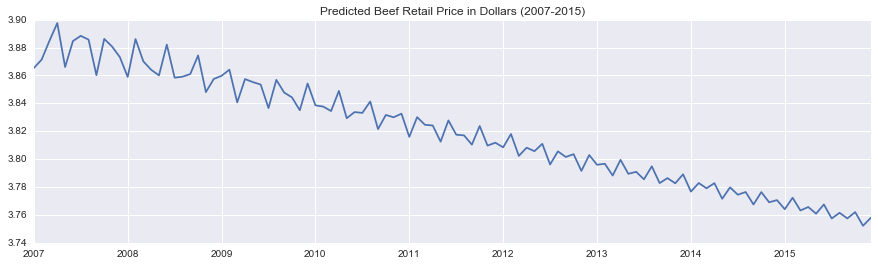

In [142]:
beef_retail_model = sm.tsa.ARIMA(beef_retail_train, (6,0,4)).fit()

beef_retail_predictions = beef_retail_model.predict(
    '2007-01-31',
    '2015-12-31',
    dynamic=True
)

print ("Mean absolute error: ", mean_absolute_error(beef_retail_test, beef_retail_predictions))
beef_retail_predictions.plot(figsize=(15,4),
                            title='Predicted Beef Retail Price in Dollars (2007-2015)')
beef_retail_model.summary()

In [141]:
pork_retail_train = meat_oil_grains.Pork_Retail_Price[:252]
pork_retail_test = meat_oil_grains.Pork_Retail_Price[252:]

('Mean absolute error: ', 0.59598441668772162)


/Users/NickPerino/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      Pork_Retail_Price   No. Observations:                  252
Model:                     ARMA(6, 3)   Log Likelihood                 512.041
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 28 Apr 2016   AIC                          -1002.082
Time:                        13:48:35   BIC                           -963.258
Sample:                    01-31-1986   HQIC                          -986.460
                         - 12-31-2006                                         
===========================================================================================
                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                       2.3126      0.908      2.546      0.012         0.532     4.093
ar.L1.Pork_Retail_Price     2.0707      0.006    328.933      0.000         2.058     2.083
ar.L2.Pork_Retail_Price    -0.7087        nan        nan        nan           nan       nan
ar.L3.Pork_Retail_Price    -1.3307        nan        nan        nan           nan       nan
ar.L4.Pork_Retail_Price     1.0566      0.018     58.627      0.000         1.021     1.092
ar.L5.Pork_Retail_Price     0.0002      0.019      0.013      0.990        -0.037     0.037
ar.L6.Pork_Retail_Price    -0.0884      0.010     -8.930      0.000        -0.108    -0.069
ma.L1.Pork_Retail_Price    -0.9530      0.042    -22.568      0.000        -1.036    -0.870
ma.L2.Pork_Retail_Price    -0.3961      0.068     -5.858      0.000        -0.529    -0.264
ma.L3.Pork_Retail_Price     0.7893      0.041     19.405      0.000         0.710     0.869
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8668           -0.5083j            1.0048           -0.0844
AR.2            0.8668           +0.5083j            1.0048            0.0844
AR.3            1.0008           -0.0000j            1.0008           -0.0000
AR.4           -1.2336           -0.0000j            1.2336           -0.5000
AR.5            2.3546           -0.0000j            2.3546           -0.0000
AR.6           -3.8527           -0.0000j            3.8527           -0.5000
MA.1           -1.2582           -0.0000j            1.2582           -0.5000
MA.2            0.8800           -0.4823j            1.0035           -0.0798
MA.3            0.8800           +0.4823j            1.0035            0.0798
-----------------------------------------------------------------------------
"""

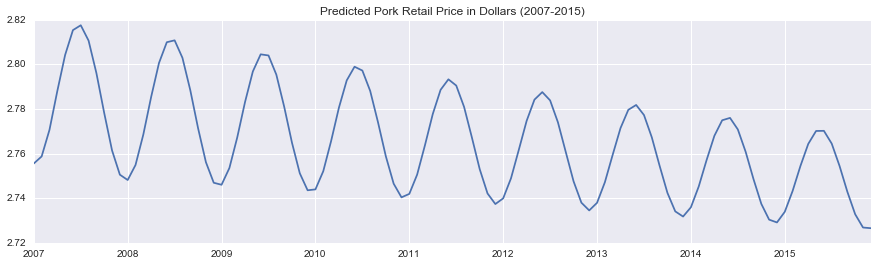

In [161]:
pork_retail_model = sm.tsa.ARIMA(pork_retail_train, (6,0,3)).fit()

pork_retail_predictions = pork_retail_model.predict(
    '2007-01-31',
    '2015-12-31',
    dynamic=True
)

print ("Mean absolute error: ", mean_absolute_error(pork_retail_test, pork_retail_predictions))
pork_retail_predictions.plot(figsize=(15,4),
                            title='Predicted Pork Retail Price in Dollars (2007-2015)')
pork_retail_model.summary()

In [163]:
chicken_retail_train = meat_oil_grains.Chicken_Retail_Price[:252]
chicken_retail_test = meat_oil_grains.Chicken_Retail_Price[252:]

('Mean absolute error: ', 0.31775799524688492)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                               
================================================================================
Dep. Variable:     Chicken_Retail_Price   No. Observations:                  252
Model:                       ARMA(6, 1)   Log Likelihood                 508.580
Method:                         css-mle   S.D. of innovations              0.032
Date:                  Thu, 28 Apr 2016   AIC                           -999.160
Time:                          13:54:34   BIC                           -967.395
Sample:                      01-31-1986   HQIC                          -986.379
                           - 12-31-2006                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
const                          1.4570      0.095     15.301      0.000         1.270     1.644
ar.L1.Chicken_Retail_Price     1.5756      0.164      9.607      0.000         1.254     1.897
ar.L2.Chicken_Retail_Price    -0.5426      0.185     -2.929      0.004        -0.906    -0.180
ar.L3.Chicken_Retail_Price    -0.0942      0.120     -0.784      0.434        -0.330     0.141
ar.L4.Chicken_Retail_Price     0.1362      0.120      1.132      0.259        -0.100     0.372
ar.L5.Chicken_Retail_Price    -0.2767      0.116     -2.382      0.018        -0.504    -0.049
ar.L6.Chicken_Retail_Price     0.1954      0.064      3.040      0.003         0.069     0.321
ma.L1.Chicken_Retail_Price    -0.6248      0.160     -3.917      0.000        -0.937    -0.312
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4457           -0.0000j            1.4457           -0.5000
AR.2           -0.1901           -1.4942j            1.5063           -0.2701
AR.3           -0.1901           +1.4942j            1.5063            0.2701
AR.4            1.1153           -0.5462j            1.2418           -0.0725
AR.5            1.1153           +0.5462j            1.2418            0.0725
AR.6            1.0116           -0.0000j            1.0116           -0.0000
MA.1            1.6005           +0.0000j            1.6005            0.0000
-----------------------------------------------------------------------------
"""

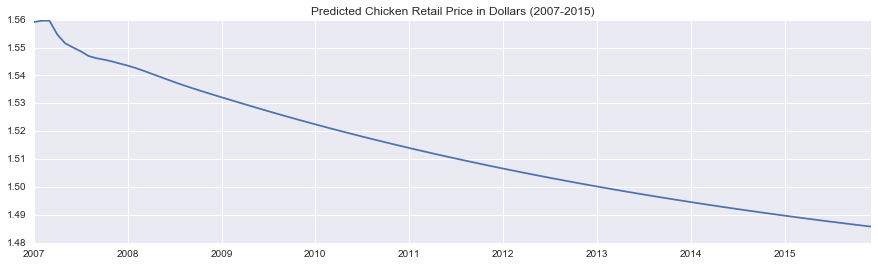

In [175]:
chicken_retail_model = sm.tsa.ARIMA(chicken_retail_train, (6,0,1)).fit()

chicken_retail_predictions = chicken_retail_model.predict(
    '2007-01-31',
    '2015-12-31',
    dynamic=True
)

print ("Mean absolute error: ", mean_absolute_error(chicken_retail_test, chicken_retail_predictions))
chicken_retail_predictions.plot(figsize=(15,4),
                            title='Predicted Chicken Retail Price in Dollars (2007-2015)')
chicken_retail_model.summary()

In [176]:
oil_train = meat_oil_grains.Oil_Price[:252]
oil_test = meat_oil_grains.Oil_Price[252:]

('Mean absolute error: ', 24.529554692414496)


/Users/NickPerino/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Oil_Price   No. Observations:                  252
Model:                     ARMA(9, 0)   Log Likelihood                -555.863
Method:                       css-mle   S.D. of innovations              2.131
Date:                Thu, 28 Apr 2016   AIC                           1133.726
Time:                        14:03:39   BIC                           1172.549
Sample:                    01-31-1986   HQIC                          1149.348
                         - 12-31-2006                                         
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              26.7368        nan        nan        nan           nan       nan
ar.L1.Oil_Price     1.2728   1.28e-05   9.91e+04      0.000         1.273     1.273
ar.L2.Oil_Price    -0.5228   7.76e-06  -6.73e+04      0.000        -0.523    -0.523
ar.L3.Oil_Price     0.3236   9.29e-06   3.48e+04      0.000         0.324     0.324
ar.L4.Oil_Price    -0.2907   5.45e-06  -5.33e+04      0.000        -0.291    -0.291
ar.L5.Oil_Price     0.3621    7.6e-06   4.76e+04      0.000         0.362     0.362
ar.L6.Oil_Price    -0.3293   1.11e-05  -2.98e+04      0.000        -0.329    -0.329
ar.L7.Oil_Price     0.2691   5.91e-06   4.55e+04      0.000         0.269     0.269
ar.L8.Oil_Price    -0.1545   2.62e-06   -5.9e+04      0.000        -0.154    -0.154
ar.L9.Oil_Price     0.0695   1.37e-06   5.09e+04      0.000         0.070     0.070
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9981           -0.7096j            1.2247           -0.4016
AR.2           -0.9981           +0.7096j            1.2247            0.4016
AR.3            1.0000           -0.0000j            1.0000           -0.0000
AR.4           -0.2663           -1.4709j            1.4948           -0.2785
AR.5           -0.2663           +1.4709j            1.4948            0.2785
AR.6            1.2246           -0.6826j            1.4020           -0.0809
AR.7            1.2246           +0.6826j            1.4020            0.0809
AR.8            0.6509           -1.3267j            1.4778           -0.1774
AR.9            0.6509           +1.3267j            1.4778            0.1774
-----------------------------------------------------------------------------
"""

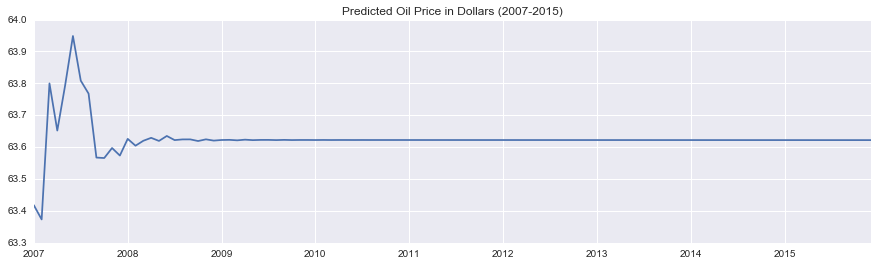

In [206]:
oil_model = sm.tsa.ARIMA(oil_train, (9,0,0)).fit()

oil_predictions = oil_model.predict(
    '2007-01-31',
    '2015-12-31',
    dynamic=True
)

print ("Mean absolute error: ", mean_absolute_error(oil_test, oil_predictions))
oil_predictions.plot(figsize=(15,4),
                            title='Predicted Oil Price in Dollars (2007-2015)')
oil_model.summary()

In [217]:
corn_train = grains.Corn_Price[33:135]
corn_test = grains.Corn_Price[135:]

('Mean absolute error: ', 1.8199403366647717)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Corn_Price   No. Observations:                  102
Model:                     ARMA(1, 3)   Log Likelihood                 -25.624
Method:                       css-mle   S.D. of innovations              0.308
Date:                Thu, 28 Apr 2016   AIC                             63.248
Time:                        14:13:02   BIC                             78.998
Sample:                    12-31-1900   HQIC                            69.626
                         - 12-31-2001                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                1.2757      0.507      2.516      0.014         0.282     2.269
ar.L1.Corn_Price     0.9752      0.025     38.755      0.000         0.926     1.024
ma.L1.Corn_Price    -0.1024      0.099     -1.038      0.302        -0.296     0.091
ma.L2.Corn_Price    -0.1065      0.109     -0.973      0.333        -0.321     0.108
ma.L3.Corn_Price    -0.2484      0.117     -2.130      0.036        -0.477    -0.020
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0255           +0.0000j            1.0255            0.0000
MA.1            1.3818           -0.0000j            1.3818           -0.0000
MA.2           -0.9052           -1.4472j            1.7070           -0.3390
MA.3           -0.9052           +1.4472j            1.7070            0.3390
-----------------------------------------------------------------------------
"""

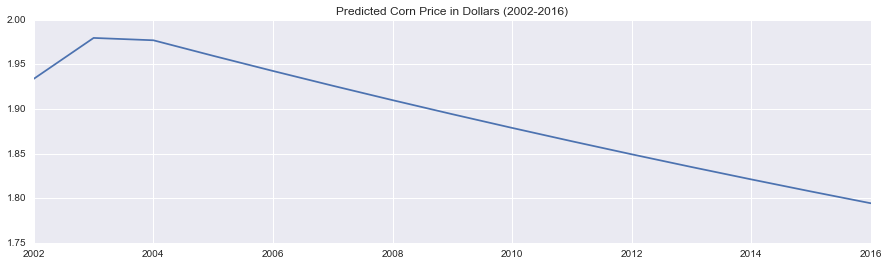

In [239]:
corn_model = sm.tsa.ARIMA(corn_train, (1,0,3)).fit()

corn_predictions = corn_model.predict(
    '2002-12-31',
    '2016-12-31',
    dynamic=True
)

print ("Mean absolute error: ", mean_absolute_error(corn_test, corn_predictions))
corn_predictions.plot(figsize=(15,4),
                            title='Predicted Corn Price in Dollars (2002-2016)')
corn_model.summary()

## Regression Modeling for Feature Relationship

In [285]:
X = train[['Oil_Price', 'Corn_Price','Barley_Price','Oats_Price', 'Sorghum_Price']]
y = train['Beef_Retail_Price']

lm_beef = smf.ols(formula='y ~ X', data=train).fit()
lm_beef.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     25.07
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           5.46e-19
Time:                        15:05:53   Log-Likelihood:                 72.907
No. Observations:                 180   AIC:                            -133.8
Df Residuals:                     174   BIC:                            -114.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.1717      0.102     21.347      0.000         1.971     2.373
X[0]           0.0130      0.004      3.695      0.000         0.006     0.020
X[1]          -0.3005      0.223     -1.350      0.179        -0.740     0.139
X[2]           0.4846      0.112      4.324      0.000         0.263     0.706
X[3]          -0.3205      0.057     -5.614      0.000        -0.433    -0.208
X[4]           0.1958      0.179      1.097      0.274        -0.157     0.548
==============================================================================
Omnibus:                       17.348   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.055
Skew:                          -0.817   Prob(JB):                     4.42e-05
Kurtosis:                       3.074   Cond. No.                         494.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [286]:
X = train[['Oil_Price', 'Corn_Price','Barley_Price','Oats_Price', 'Sorghum_Price']]
y = train['Pork_Retail_Price']

lm_pork = smf.ols(formula='y ~ X', data=train).fit()
lm_pork.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     57.12
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           6.20e-35
Time:                        15:06:06   Log-Likelihood:                 104.11
No. Observations:                 180   AIC:                            -196.2
Df Residuals:                     174   BIC:                            -177.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.4773      0.086     17.269      0.000         1.308     1.646
X[0]           0.0047      0.003      1.590      0.114        -0.001     0.011
X[1]           0.2328      0.187      1.243      0.215        -0.137     0.602
X[2]           0.9092      0.094      9.648      0.000         0.723     1.095
X[3]          -0.5554      0.048    -11.571      0.000        -0.650    -0.461
X[4]          -0.5363      0.150     -3.573      0.000        -0.833    -0.240
==============================================================================
Omnibus:                       17.582   Durbin-Watson:                   0.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.696
Skew:                          -0.687   Prob(JB):                     3.21e-05
Kurtosis:                       3.932   Cond. No.                         494.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [287]:
X = train[['Oil_Price', 'Corn_Price','Barley_Price','Oats_Price', 'Sorghum_Price']]
y = train['Chicken_Retail_Price']

lm_chicken = smf.ols(formula='y ~ X', data=train).fit()
lm_chicken.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     23.55
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           4.83e-18
Time:                        15:06:15   Log-Likelihood:                 201.10
No. Observations:                 180   AIC:                            -390.2
Df Residuals:                     174   BIC:                            -371.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0842      0.050     21.723      0.000         0.986     1.183
X[0]          -0.0009      0.002     -0.510      0.611        -0.004     0.003
X[1]           0.0519      0.109      0.475      0.635        -0.164     0.267
X[2]           0.3508      0.055      6.380      0.000         0.242     0.459
X[3]          -0.1577      0.028     -5.631      0.000        -0.213    -0.102
X[4]          -0.1392      0.088     -1.590      0.114        -0.312     0.034
==============================================================================
Omnibus:                       21.827   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.809
Skew:                          -0.773   Prob(JB):                     9.15e-07
Kurtosis:                       4.147   Cond. No.                         494.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

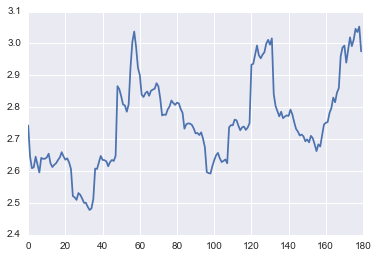

In [302]:
plt.plot(lm_beef.predict(test['Beef_Retail_Price']))

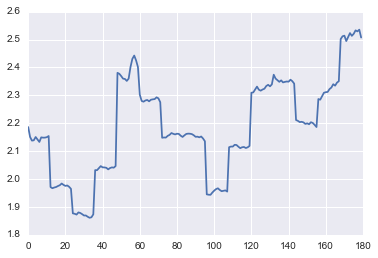

In [291]:
plt.plot(lm_pork.predict(test['Pork_Retail_Price']))

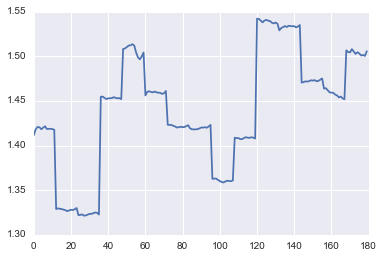

In [292]:
plt.plot(lm_chicken.predict(test['Chicken_Retail_Price']))

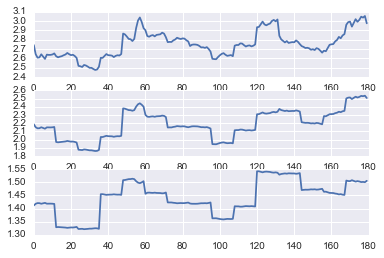

In [304]:
plt.figure(1)
plt.subplot(311)
plt.plot(lm_beef.predict(test['Beef_Retail_Price']))

plt.subplot(312)
plt.plot(lm_pork.predict(test['Pork_Retail_Price']))

plt.subplot(313)
plt.plot(lm_chicken.predict(test['Chicken_Retail_Price']))
plt.show()